## AE-MSP plotting
* losses vs epoch
* evaluate orthogonality of projection matrix
* true vs predicted labels

In [1]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from behavenet import get_user_dir, make_dir_if_not_exists

save_outputs = False  # true to save figures/movies to user's figure directory
format = 'png'  # figure format ('png' | 'jpeg' | 'pdf'); movies saved as mp4

# pixel mse vs epoch

In [2]:
from behavenet.plotting import load_metrics_csv_as_df
# set model info
dataset = 'dipoppa'
n_ae_latents = 6  # n_labels will be added to this
iters = 400
frac = '1.0'
hparams = {
    'data_dir': get_user_dir('data'),
    'save_dir': get_user_dir('save'),
    'model_type': 'conv'}


lab = 'dipoppa'
expt = 'full_trial'
n_labels = 3


models = ['ae', 'cond-ae-msp']
# models = ['ae', 'labels-images', 'cond-ae-msp']
metrics_dfs = []
i = 0

# ae
model_class = 'ae'
if model_class in models:
    print('loading ae model results')
    hparams['experiment_name'] = 'latent_search'
    hparams['n_ae_latents'] = n_ae_latents + n_labels
    hparams['model_class'] = model_class
    metrics_list = ['loss']
    metrics_dfs.append(load_metrics_csv_as_df(hparams, lab, expt, metrics_list))
    metrics_dfs[i] = metrics_dfs[i].rename(columns={'loss': 'loss_mse'})
    metrics_dfs[i]['model'] = '%s (%i latents)' % (model_class, hparams['n_ae_latents'])
    i += 1
    
# cond-ae
model_class = 'cond-ae'
if model_class in models:
    print('loading cond-ae model results')
    hparams['experiment_name'] = 'iters-%i_frac-%s' % (iters, frac)
    hparams['n_ae_latents'] = n_ae_latents
    hparams['model_class'] = model_class
    metrics_list = ['loss']
    metrics_dfs.append(load_metrics_csv_as_df(hparams, lab, expt, metrics_list))
    metrics_dfs[i] = metrics_dfs[i].rename(columns={'loss': 'loss_mse'})
    metrics_dfs[i]['model'] = '%s (%i latents + %i labels)' % (
        model_class, hparams['n_ae_latents'], n_labels)
    i += 1

# cond-ae-msp
model_class = 'cond-ae-msp'
if model_class in models:
    print('loading cond-ae-msp model results')
    hparams['experiment_name'] = 'pupil_msp'
    hparams['n_ae_latents'] = n_ae_latents + n_labels
    hparams['model_class'] = model_class
    metrics_list = ['loss_mse']
    expt = 'pupil_msp'
    metrics_dfs.append(load_metrics_csv_as_df(hparams, lab, expt, metrics_list))
    metrics_dfs[i]['model'] = '%s (%i latents)' % (model_class, hparams['n_ae_latents'])
    i += 1

# labels-images
model_class = 'labels-images'
if model_class in models:
    print('loading labels-images model results')
    hparams['experiment_name'] = 'iters-%i_frac-%s' % (iters, frac)
#     hparams['experiment_name'] = 'iters-500_frac-0.5'
    hparams['model_class'] = model_class
    metrics_list = ['loss']
    metrics_dfs.append(load_metrics_csv_as_df(hparams, lab, expt, metrics_list))
    metrics_dfs[i] = metrics_dfs[i].rename(columns={'loss': 'loss_mse'})
    metrics_dfs[i]['model'] = '%s (%i labels)' % (model_class, n_labels)
    i += 1

metrics_df = pd.concat(metrics_dfs, sort=False)
print('done')

loading ae model results
loading cond-ae-msp model results
done


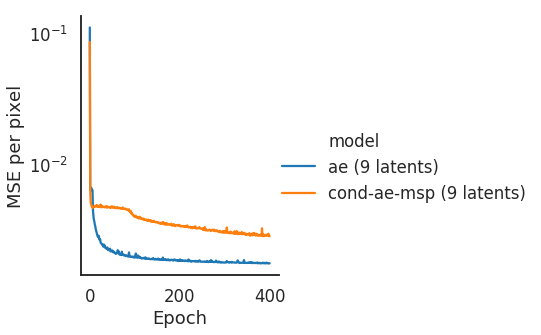

In [3]:
# plot data
sns.set_style('white')
sns.set_context('talk')
    
data_queried = metrics_df[
    (metrics_df.epoch < 400) 
    & ~pd.isna(metrics_df.loss_mse)
    & (metrics_df.dtype == 'val')]
splt = sns.relplot(x='epoch', y='loss_mse', hue='model', kind='line', data=data_queried)
splt.ax.set_xlabel('Epoch')
splt.ax.set_ylabel('MSE per pixel')
splt.ax.set_yscale('log')

if save_outputs:
    save_file = os.path.join(get_user_dir('fig'), 'ae', dataset, 'loss_vs_epoch')
    make_dir_if_not_exists(save_file)
    plt.savefig(save_file + '.' + format, dpi=300, format=format)

plt.show()

# metrics vs epoch for different msp weights

In [4]:
from behavenet.plotting import load_metrics_csv_as_df
# set model info
dataset = 'dipoppa'
hparams = {
    'data_dir': get_user_dir('data'),
    'save_dir': get_user_dir('save'),
    'experiment_name': 'pupil_msp',
    'model_class': 'cond-ae-msp',
    'model_type': 'conv',
    'rng_seed_data': 0,
    'trial_splits': '8;1;1;0',
    'train_frac': 1.0,
    'rng_seed_model': 0,
    'fit_sess_io_layers': False,
    'learning_rate': 1e-4,
    'l2_reg': 0,
    'conditional_encoder': False}

if dataset == 'ibl':
    lab = 'ibl'
    expt = 'ephys'
    n_labels = 8
    msp_weights = [1e-4, 1e-5, 1e-6]
elif dataset == 'musall':
    lab = 'musall'
    expt = 'vistrained'
    n_labels = 6
    msp_weights = [1e-4, 1e-5, 1e-6]
elif dataset == 'dipoppa':
    lab = 'dipoppa'
    expt = 'pupil_msp'
    n_labels = 3
#     msp_weights = [1e0, 1e-1, 1e-2, 1e-3]
    msp_weights = [1e0]
else:
    raise Exception
    
n_ae_latents = 6 + n_labels
hparams['n_ae_latents'] = n_ae_latents

metrics_list = ['loss', 'loss_mse', 'loss_msp', 'r2']
metrics_dfs = []
i = 0
for msp_weight in msp_weights:
    hparams['msp_weight'] = msp_weight
    # try:
    print('loading results with weight=%e' % msp_weight)
    metrics_dfs.append(load_metrics_csv_as_df(
        hparams, lab, expt, metrics_list))
    msp_str = str(msp_weight)
    metrics_dfs[i]['msp_weight'] = msp_str[0] + ' ' + msp_str[1:]
    i += 1
    #except TypeError:
    #    print('could not find model for weight=%e; skipping' % msp_weight)
    #    continue
metrics_df = pd.concat(metrics_dfs, sort=False)
print('done')

loading results with weight=1.000000e+00
done


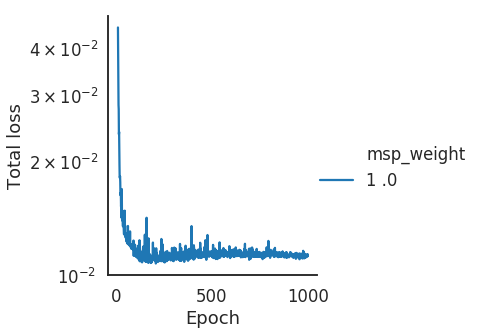

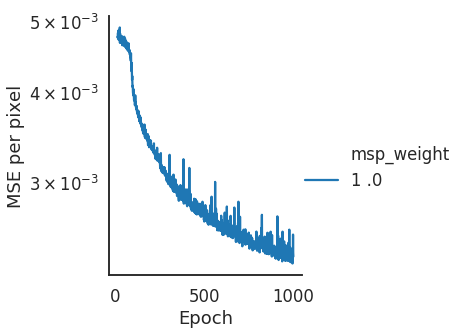

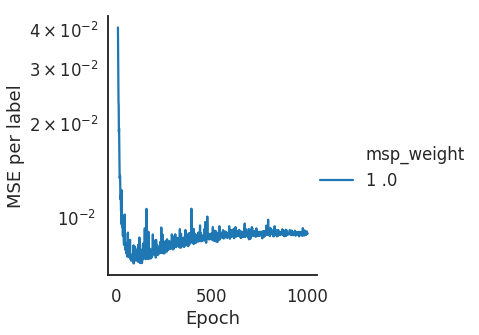

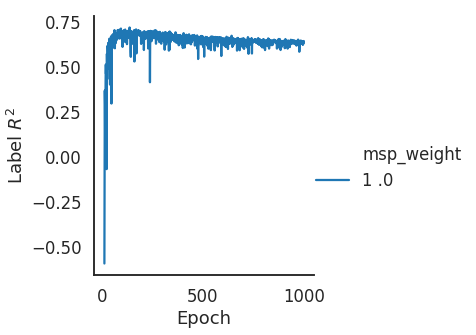

In [5]:
# plot data
sns.set_style('white')
sns.set_context('talk')

ys = metrics_list

for y in ys:
    
    data_queried = metrics_df[
        (metrics_df.epoch > 10) 
        & ~pd.isna(metrics_df.loss)
        & (metrics_df.dtype == 'val')]
    splt = sns.relplot(x='epoch', y=y, hue='msp_weight', kind='line', data=data_queried)
    splt.ax.set_xlabel('Epoch')
    if y == 'loss':
        splt.ax.set_ylabel('Total loss')
        splt.ax.set_yscale('log')
    elif y == 'loss_mse':
        splt.ax.set_ylabel('MSE per pixel')
        splt.ax.set_yscale('log')
    elif y == 'loss_msp':
        splt.ax.set_ylabel('MSE per label')
        splt.ax.set_yscale('log')
    elif y == 'r2':
        splt.ax.set_ylabel('Label $R^2$')

    if save_outputs:
        save_file = os.path.join(get_user_dir('fig'), 'ae', dataset, 'loss_vs_epoch')
        make_dir_if_not_exists(save_file)
        plt.savefig(save_file + '.' + format, dpi=300, format=format)

    plt.show()

# comparison videos

### all models comparison

In [6]:
from behavenet.plotting.ae_utils import make_reconstruction_movie
from behavenet.plotting.cond_ae_utils import get_model_input
from behavenet.fitting.eval import get_reconstruction
from behavenet.fitting.utils import get_best_model_and_data

def make_reconstruction_movie_wrapper(
        hparams, save_file, model_info, trial_idxs=None, sess_idx=0, max_frames=400, 
        frame_rate=15, layout_pattern=None):
    """Produce movie with original video, reconstructed video, and residual.

    This is a high-level function that loads the model described in the hparams dictionary and
    produces the necessary predicted video frames.

    Parameters
    ----------
    hparams : :obj:`dict`
        needs to contain enough information to specify an autoencoder
    save_file : :obj:`str`
        full save file (path and filename)
    trial_idxs : :obj:`list`, optional
        list of test trials to construct videos from; if :obj:`NoneType`, use first test 
        trial
    sess_idx : :obj:`int`, optional
        session index into data generator
    max_frames : :obj:`int`, optional
        maximum number of frames to animate from a trial
    frame_rate : :obj:`float`, optional
        frame rate of saved movie
        
    """

    n_labels = hparams['n_labels']
    n_latents = hparams['n_ae_latents']
    expt_name = hparams['experiment_name']
    
#     def set_default_title(titles, expt, n_latents, n_labels):
#         if titles is None:

    # set up models to fit
    titles = ['Original']
    for model in model_info:
        if model['model_class'] == 'ae':
            title_str = 'AE (%i latents)' % (n_latents + n_labels)
        elif model['model_class'] == 'labels-images':
            title_str = 'Labels only (%i labels)' % n_labels
        elif model['model_class'] == 'cond-ae':
            title_str = 'Cond-AE (%i/%i latents/labels)' % (n_latents, n_labels)
        elif model['model_class'] == 'cond-ae-msp':
            title_str = 'Cond-AE-MSP (%i latents)' % (n_latents + n_labels)
        else:
            raise NotImplementedError
        titles.append(model.get('title', title_str))
        
    # insert original video at front
    model_info.insert(0, {'model_class': None})

    ims_recon = [[] for _ in titles]
    
    trial_idxs = [0] if trial_idxs is None else trial_idxs    
    for i, model in enumerate(model_info):

        if i == 0:
            continue
            
        # further specify model
        version = model.get('version', 'best')
        hparams['experiment_name'] = model.get('experiment_name', expt_name)
        hparams['model_class'] = model.get('model_class')
        if hparams['model_class'] == 'ae':
            from behavenet.models import AE as Model
            hparams['n_ae_latents'] = n_latents + n_labels
        elif hparams['model_class'] == 'labels-images':
            from behavenet.models import ConvDecoder as Model
        elif hparams['model_class'] == 'cond-ae':
            from behavenet.models import ConditionalAE as Model
            hparams['n_ae_latents'] = n_latents
        elif hparams['model_class'] == 'cond-ae-msp':
            from behavenet.models import AEMSP as Model
            hparams['n_ae_latents'] = n_latents + n_labels
        else:
            raise NotImplementedError(
                '"%s" is an invalid model class' % hparams['model_class'])
        model_ae, data_generator = get_best_model_and_data(hparams, Model, version=version)

        # get images
        for trial_idx in trial_idxs:

            # get model inputs
            ims_orig_pt, ims_orig_np, _, labels_pt, _, labels_2d_pt, _ = get_model_input(
                data_generator, hparams, model_ae, trial_idx=trial_idx, sess_idx=sess_idx,
                max_frames=max_frames, compute_latents=False, compute_2d_labels=False)
            
            # get model outputs
            if hparams['model_class'] == 'labels-images':
                ims_recon_tmp = get_reconstruction(model_ae, labels_pt)
            else:
                ims_recon_tmp = get_reconstruction(
                    model_ae, ims_orig_pt, labels=labels_pt, labels_2d=labels_2d_pt)
            ims_recon[i].append(ims_recon_tmp)
                
            # add a couple gray frames to separate trials
            if trial_idx != trial_idxs[-1]:
                _, n, y_p, x_p = ims_recon[i][-1].shape
                ims_recon[i].append(0.1 * np.ones((5, n, y_p, x_p)))

            if i == 1:  # deal with original frames only once
                ims_recon[0].append(ims_orig_np)
                # add a couple gray frames to separate trials
                if trial_idx != trial_idxs[-1]:
                    _, n, y_p, x_p = ims_recon[0][-1].shape
                    ims_recon[0].append(0.1 * np.ones((5, n, y_p, x_p)))
        
    for i, ims in enumerate(ims_recon):
        ims_recon[i] = np.concatenate(ims, axis=0)
    
    if layout_pattern is None:
        if len(titles) < 4:
            n_rows, n_cols = 1, 1
        elif len(titles) == 4:
            n_rows, n_cols = 2, 2
        elif len(titles) > 4:
            n_rows, n_cols = 2, 3
        else:
            raise ValueError('too many models')
    else:
        assert np.sum(layout_pattern) == len(ims_recon)
        n_rows, n_cols = layout_pattern.shape
        count = 0
        for pos_r in layout_pattern:
            for pos_c in pos_r:
                if not pos_c:
                    ims_recon.insert(count, [])
                    titles.insert(count, [])
                count += 1
        
    make_reconstruction_movie(
        ims=ims_recon, titles=titles, n_rows=n_rows, n_cols=n_cols, save_file=save_file, 
        frame_rate=frame_rate)

In [ ]:
os.path.exists('')

Loading model defined in /home/samsung_2tb_ssd/yoni/results/dipoppa/MSP_pupil/MD0ST5/4/cond-ae-msp/conv/09_latents/pupil_msp/version_1/meta_tags.pkl
saving video to figures/ae/dipoppa/D=06_decoder-reconstructions_trial=[0, 1, 2].mp4...done


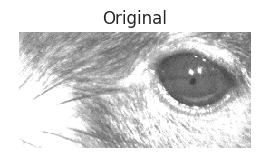

In [7]:
from behavenet.fitting.utils import get_expt_dir
from behavenet.fitting.utils import get_session_dir
from behavenet.fitting.utils import get_lab_example

dataset = 'dipoppa'
n_ae_latents = 6

# movie info
save_outputs = True
frame_rate = 20  # frame rate of rendered movie, not original behavioral video

# set model info
sess_idx = 0  # when using a multisession, this determines which session is used
hparams = {
    'data_dir': get_user_dir('data'),
    'save_dir': get_user_dir('save'),
    'experiment_name': None,
    # 'model_class': 'cond-ae',
    'model_type': 'conv',
    'n_ae_latents': n_ae_latents,
    'conditional_encoder': False,
}

if dataset == 'ibl':
    lab = 'ibl'
    expt = 'ephys'
    hparams['n_labels'] = 8
elif dataset == 'musall':
    lab = 'musall'
    expt = 'vistrained'
    hparams['n_labels'] = 6
elif dataset == 'dipoppa':
    lab = 'dipoppa'
    expt = 'pupil_msp'
    hparams['n_labels'] = 3
else:
    raise Exception
    
# programmatically fill out other hparams options
get_lab_example(hparams, lab, expt)
# hparams['session_dir'], sess_ids = get_session_dir(hparams)
# hparams['expt_dir'] = get_expt_dir(hparams)

model_info = [
#     {
#         'model_class': 'ae', 
#         'experiment_name': 'latent_search'},
#     {
#         'model_class': 'cond-ae',
#         'experiment_name': 'iters-400_frac-1.0'},
   
    {
        'model_class': 'cond-ae-msp',
        'experiment_name': 'pupil_msp'},
]

trial_idxs = [0, 1, 2]
filename = 'D={0:02d}_decoder-reconstructions_trial={1}'.format(
    hparams['n_ae_latents'], trial_idxs)
save_file = os.path.join(get_user_dir('fig'), 'ae', dataset, filename)

make_reconstruction_movie_wrapper(
    hparams, save_file=save_file, trial_idxs=trial_idxs, model_info=model_info,
    frame_rate=frame_rate)

### compare ae-msp models with different msp loss weights

In [ ]:
from behavenet.fitting.utils import get_expt_dir
from behavenet.fitting.utils import get_session_dir
from behavenet.fitting.utils import get_lab_example

dataset = 'dipoppa'
n_ae_latents = 2  # not including label-related latents

# movie info
save_outputs = True
frame_rate = 20  # frame rate of rendered movie, not original behavioral video

# set model info
sess_idx = 0  # when using a multisession, this determines which session is used
hparams = {
    'data_dir': get_user_dir('data'),
    'save_dir': get_user_dir('save'),
    'experiment_name': None,
    # 'model_class': 'cond-ae',
    'model_type': 'conv',
    'n_ae_latents': n_ae_latents,
    'conditional_encoder': False,
}

if dataset == 'ibl':
    lab = 'ibl'
    expt = 'ephys'
    hparams['n_labels'] = 8
elif dataset == 'dipoppa':
    lab = 'dipoppa'
    expt = 'pupil'
    hparams['n_labels'] = 3
else:
    raise Exception
    
# programmatically fill out other hparams options
get_lab_example(hparams, lab, expt)
# hparams['session_dir'], sess_ids = get_session_dir(hparams)
# hparams['expt_dir'] = get_expt_dir(hparams)

model_info = [
    {
        'model_class': 'cond-ae-msp',
        'experiment_name': 'iters-400_frac-1.0',
        'title': 'AE-MSP: 1e-1',
        'version': 3},
#         'title': 'AE-MSP: 1e-4',
#         'version': 1},
    {
        'model_class': 'cond-ae-msp',
        'experiment_name': 'iters-400_frac-1.0',
        'title': 'AE-MSP: 1e-2',
        'version': 1},
#         'title': 'AE-MSP: 1e-5',
#         'version': 0},
    {
        'model_class': 'cond-ae-msp',
        'experiment_name': 'iters-400_frac-1.0',
        'title': 'AE-MSP: 1e-3',
        'version': 0},
#         'title': 'AE-MSP: 1e-6',
#         'version': 2},
]

layout = np.array([[False, True, False], [True, True, True]])
trial_idxs = [0, 1, 2]
filename = 'D={0:02d}_ae-msp-reconstructions_trial={1}'.format(
    hparams['n_ae_latents'], trial_idxs)
save_file = os.path.join(get_user_dir('fig'), 'ae-msp', dataset, filename)
    
make_reconstruction_movie_wrapper(
    hparams, model_info=model_info, save_file=save_file, trial_idxs=trial_idxs,
    frame_rate=frame_rate, layout_pattern=layout)

### Make vanilla reconstruction movies

In [ ]:
from behavenet.plotting.ae_utils import make_ae_reconstruction_movie_wrapper
from behavenet.data.utils import get_data_generator_inputs
from behavenet.data.data_generator import ConcatSessionsGenerator
from behavenet.fitting.utils import get_expt_dir
from behavenet.fitting.utils import get_session_dir
from behavenet.fitting.utils import get_lab_example

# movie info
save_outputs = True
include_linear = False  # True to include reconstructions from linear models; need training

# set model info
version = 'best'  # test-tube version; 'best' finds the version with the lowest mse
sess_idx = 0  # when using a multisession, this determines which session is used
hparams = {
    'data_dir': get_user_dir('data'),
    'save_dir': get_user_dir('save'),
#     'experiment_name': 'iters-400_frac-1.0',
    'experiment_name': 'ae-example-500-new-arch-2',
    'lin_experiment_name': 'ae-example',
    'model_class': 'ae',
    'model_type': 'conv',
    'n_ae_latents': 2,
    'frame_rate': 20,  # frame rate of rendered movie, not original behavioral video
}

# programmatically fill out other hparams options
get_lab_example(hparams, 'ibl', 'ephys')   
hparams['session_dir'], sess_ids = get_session_dir(hparams)
hparams['expt_dir'] = get_expt_dir(hparams)

# load data generator to find a test trial
hparams, signals, transforms, paths = get_data_generator_inputs(hparams, sess_ids)
data_generator = ConcatSessionsGenerator(
    hparams['data_dir'], sess_ids, 
    signals_list=signals, transforms_list=transforms, paths_list=paths,
    device='cpu', as_numpy=False, batch_load=True, rng_seed=0)
print(data_generator)
trial = data_generator.datasets[sess_idx].batch_idxs['test'][2]  # trial to use in movie

filename = str('D=%02i_recon_ae' % hparams['n_ae_latents'])
if include_linear:
    filename += '_wlinear'

make_ae_reconstruction_movie_wrapper(
    hparams, version=version, 
    save_file=os.path.join(get_user_dir('fig'), 'ae', filename), 
    include_linear=include_linear, trial=trial)